In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import seaborn as sns

sns.set_theme(color_codes=True)

%matplotlib inline

In [2]:
import sys
sys.path.append("..") # to import from parent directory
from dataset_loader import CSIDataset
from utils import read_all_data, read_all_data_from_files

In [5]:
all_amplitudes, all_phases, all_labels = read_all_data()

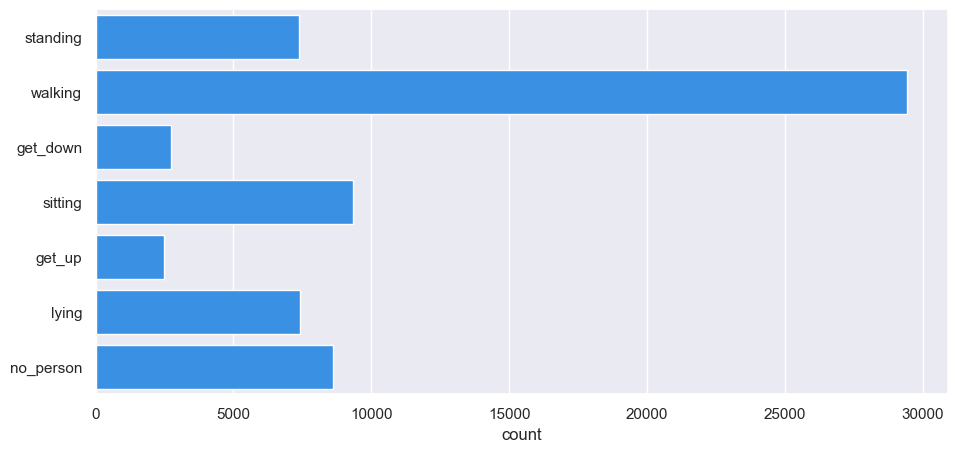

In [6]:
sns.set_theme(color_codes=True)

plt.figure(0, (11, 5))
sns_plot = sns.countplot(all_labels, color="dodgerblue", label="Compact")

# fig = sns_plot.get_figure()
# fig.savefig("out.png")

In [8]:
# plot the distribution of lengths of time series activity data

current_activity = None
current_length = 0
dist = {}

for activity in all_labels:
    if current_activity is None:
        current_activity = activity
        current_length = 1
        continue

    if activity == current_activity:
        current_length += 1
    else:
        if not(current_activity in dist):
            dist[current_activity] = []

        dist[current_activity].append(current_length)

        current_length = 1
        current_activity = activity

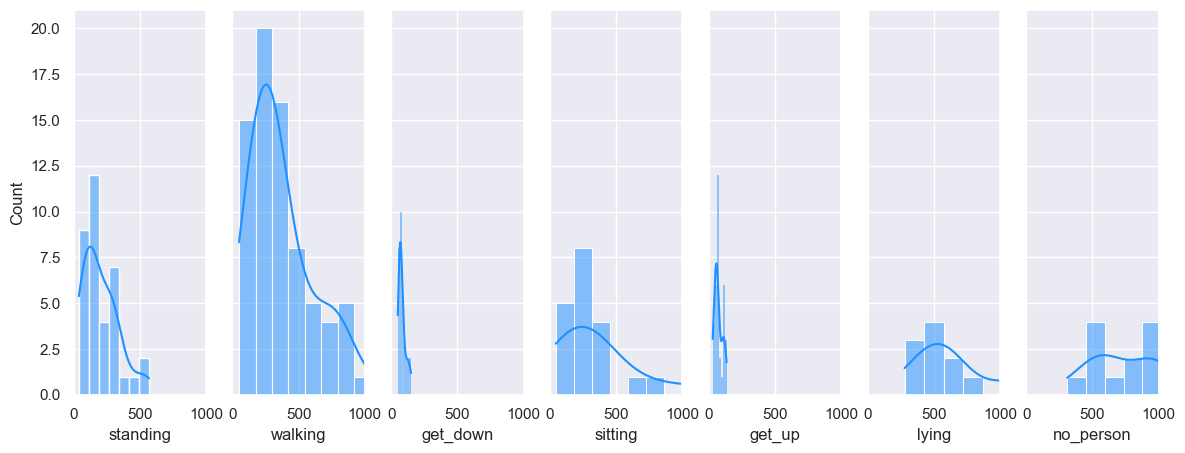

In [9]:
fig, axes = plt.subplots(1, 7, figsize=(14, 5), sharey=True, sharex=True, dpi=100)
i = 0
for key in dist:
    sns.histplot(dist[key], color="dodgerblue", kde=True, ax=axes[i])
    axes[i].set_xlabel(key)  # Set axis label for each subplot
    i += 1

plt.xlim(0, 1000)
plt.show()

In [10]:
train_dataset = CSIDataset([
    "../dataset/bedroom_lviv/1",
    "../dataset/bedroom_lviv/2",
    "../dataset/bedroom_lviv/3",
    "../dataset/vitalnia_lviv/1/",
    "../dataset/vitalnia_lviv/2/",
    "../dataset/vitalnia_lviv/3/",
    "../dataset/vitalnia_lviv/4/"
])

val_dataset = CSIDataset([
    "../dataset/bedroom_lviv/4",
    "../dataset/vitalnia_lviv/5/"
])

trn_dl = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=1)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=1)

In [11]:
class CyclicLR(_LRScheduler):

    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

def cosine(t_max, eta_min=0):
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2

    return scheduler

In [12]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x.double(), (h0.double(), c0.double()))
        # out = self.fc(out[:, -1, :].double())
        out = self.fc(out[:, -1, :].double())
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim)
        # return [t.cuda() for t in (h0, c0)]
        return [t for t in (h0, c0)]


In [26]:
for i in trn_dl:
    print(i)
    break
# trn_dl


[tensor([[[ 0.1067,  0.1190,  0.1256,  ..., -0.9905,  0.3325, -0.0684],
         [ 0.1089,  0.1222,  0.1268,  ..., -0.9993,  0.3281, -0.0785],
         [ 0.1018,  0.1148,  0.1237,  ..., -1.0053,  0.3462, -0.0831],
         ...,
         [ 0.1213,  0.1291,  0.1398,  ..., -0.8901,  0.5428, -0.1321],
         [ 0.1191,  0.1273,  0.1359,  ..., -0.8913,  0.2063, -0.0576],
         [ 0.1221,  0.1359,  0.1407,  ..., -1.0975, -0.0969, -0.1210]],

        [[ 0.1089,  0.1222,  0.1268,  ..., -0.9993,  0.3281, -0.0785],
         [ 0.1018,  0.1148,  0.1237,  ..., -1.0053,  0.3462, -0.0831],
         [ 0.1114,  0.1244,  0.1290,  ..., -1.0092,  0.3600, -0.0845],
         ...,
         [ 0.1191,  0.1273,  0.1359,  ..., -0.8913,  0.2063, -0.0576],
         [ 0.1221,  0.1359,  0.1407,  ..., -1.0975, -0.0969, -0.1210],
         [ 0.1149,  0.1274,  0.1373,  ..., -1.1007,  0.0471, -0.0737]],

        [[ 0.1018,  0.1148,  0.1237,  ..., -1.0053,  0.3462, -0.0831],
         [ 0.1114,  0.1244,  0.1290,  ..., -

In [25]:
### training loop
input_dim = 468
hidden_dim = 256
layer_dim = 3
output_dim = 7
seq_dim = 128

lr = 0.0005
n_epochs = 10
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
# model = model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

model = model.double()

for epoch in range(1, n_epochs + 1):

    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        # x_batch = x_batch.cuda()
        # y_batch = y_batch.cuda()
        
        opt.zero_grad()
        x_batch = x_batch.long()
        y_batch = y_batch.long()

        out = model(x_batch)

        print("out: ", out)
        print("y_batch: ", y_batch)

        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        sched.step()
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_dl:
        # x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()

    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training
out:  tensor([[-0.0169,  0.0425,  0.0101, -0.0369, -0.0061, -0.0261,  0.0258],
        [-0.0141,  0.0427,  0.0023, -0.0396, -0.0078, -0.0188,  0.0316],
        [-0.0126,  0.0428, -0.0027, -0.0403, -0.0086, -0.0145,  0.0342],
        [-0.0119,  0.0428, -0.0058, -0.0403, -0.0091, -0.0121,  0.0355],
        [-0.0116,  0.0431, -0.0080, -0.0400, -0.0095, -0.0108,  0.0359],
        [-0.0116,  0.0433, -0.0094, -0.0395, -0.0098, -0.0100,  0.0361],
        [-0.0116,  0.0433, -0.0101, -0.0391, -0.0100, -0.0096,  0.0362],
        [-0.0116,  0.0433, -0.0106, -0.0387, -0.0100, -0.0093,  0.0364],
        [-0.0117,  0.0432, -0.0108, -0.0384, -0.0100, -0.0091,  0.0366],
        [-0.0117,  0.0432, -0.0108, -0.0383, -0.0100, -0.0090,  0.0367],
        [-0.0118,  0.0432, -0.0108, -0.0381, -0.0099, -0.0089,  0.0368],
        [-0.0118,  0.0432, -0.0108, -0.0381, -0.0099, -0.0089,  0.0369],
        [-0.0118,  0.0433, -0.0108, -0.0380, -0.0098, -0.0088,  0.0369],
        [-0.0118,  0.043

KeyboardInterrupt: 